In [ ]:
!pip install fastf1


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [80]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import fastf1

#FastF1 coordinates

core           INFO 	Loading data for Italian Grand Prix - Qualifying [v3.7.0]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	No cached data found for session_status_data. Loading data

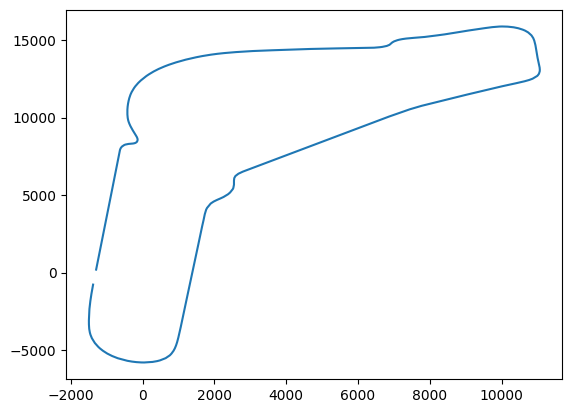

In [81]:
session = fastf1.get_session(2023, 'Monza', 'Q')
session.load()

lap = session.laps.pick_fastest()
pos = lap.get_pos_data()

circuit_info = session.get_circuit_info()

track_A = pos.loc[:, ('X', 'Y')].to_numpy()

plt.plot(track_A[:, 0], track_A[:, 1])

In [82]:
track_A

array([[-1297.,   192.],
       [-1283.,   353.],
       [-1255.,   677.],
       [-1240.,   859.],
       [-1226.,  1023.],
       [-1208.,  1224.],
       [-1188.,  1463.],
       [-1170.,  1666.],
       [-1154.,  1851.],
       [-1130.,  2130.],
       [-1105.,  2429.],
       [-1072.,  2809.],
       [-1044.,  3129.],
       [-1030.,  3300.],
       [ -995.,  3697.],
       [ -985.,  3811.],
       [ -971.,  3983.],
       [ -939.,  4345.],
       [ -911.,  4671.],
       [ -893.,  4881.],
       [ -870.,  5150.],
       [ -845.,  5438.],
       [ -827.,  5650.],
       [ -796.,  6016.],
       [ -779.,  6209.],
       [ -749.,  6567.],
       [ -727.,  6835.],
       [ -704.,  7101.],
       [ -687.,  7306.],
       [ -676.,  7440.],
       [ -659.,  7653.],
       [ -647.,  7777.],
       [ -633.,  7912.],
       [ -621.,  7987.],
       [ -608.,  8047.],
       [ -585.,  8117.],
       [ -578.,  8133.],
       [ -515.,  8231.],
       [ -484.,  8261.],
       [ -419.,  8296.],


In [83]:
print("track_A shape:", track_A.shape)
print("track_A min X:", track_A[:, 0].min(), "max X:", track_A[:, 0].max())
print("track_A min Y:", track_A[:, 1].min(), "max Y:", track_A[:, 1].max())

track_A shape: (304, 2)
track_A min X: -1499.0 max X: 11067.0
track_A min Y: -5802.0 max Y: 15884.0


# Boundary Data

In [84]:
faridata = pd.read_csv("OldData/Monza.csv")
faridata


,x_m,y_m,w_tr_right_m,w_tr_left_m
0,-0.320123,1.087714,5.739,5.932
1,0.168262,6.062191,5.735,5.929
2,0.656139,11.036647,5.731,5.926
3,1.143549,16.011082,5.727,5.923
4,1.630535,20.985493,5.723,5.920
...,...,...,...,...
1154,-2.675757,-23.791245,5.646,5.617
1155,-2.230749,-18.813605,5.664,5.680
1156,-1.768145,-13.837190,5.683,5.743
1157,-1.292482,-8.861700,5.702,5.806


In [85]:
# Centroid coordinates from the CSV and the left/right widths
track_B = faridata.loc[:, ('x_m', 'y_m')].to_numpy()
w_right = faridata['w_tr_right_m'].to_numpy()
w_left = faridata['w_tr_left_m'].to_numpy()

# Compute tangents using central differences (forward/backward at the ends)
tangents = np.zeros_like(track_B)
tangents[1:-1] = track_B[2:] - track_B[:-2]
tangents[0] = track_B[1] - track_B[0]
tangents[-1] = track_B[-1] - track_B[-2]

# Normal vectors: perpendicular to tangents. Use (-dy, dx) as the normal
normals = np.column_stack([-tangents[:, 1], tangents[:, 0]])
# Normalize normals and avoid division by zero
norm_lengths = np.linalg.norm(normals, axis=1)
norm_lengths[norm_lengths == 0] = 1.0
norm_unit = normals / norm_lengths[:, None]

# Compute boundary coordinates (right and left). Depending on orientation, signs may be swapped;
# but plotting both boundaries is the important part.
right_boundary = track_B + norm_unit * w_right[:, None]
left_boundary = track_B - norm_unit * w_left[:, None]

# Keep arrays available for later plotting/normalization
track_B.shape, right_boundary.shape, left_boundary.shape

((1159, 2), (1159, 2), (1159, 2))

In [86]:
print("track_B shape:", track_B.shape)
print("right_boundary shape:", right_boundary.shape)
print("left_boundary shape:", left_boundary.shape)
print("track_B min X:", track_B[:, 0].min(), "max X:", track_B[:, 0].max())
print("track_B min Y:", track_B[:, 1].min(), "max Y:", track_B[:, 1].max())

track_B shape: (1159, 2)
right_boundary shape: (1159, 2)
left_boundary shape: (1159, 2)
track_B min X: -5.912576 max X: 1248.056003
track_B min Y: -481.283146 max Y: 1690.038154


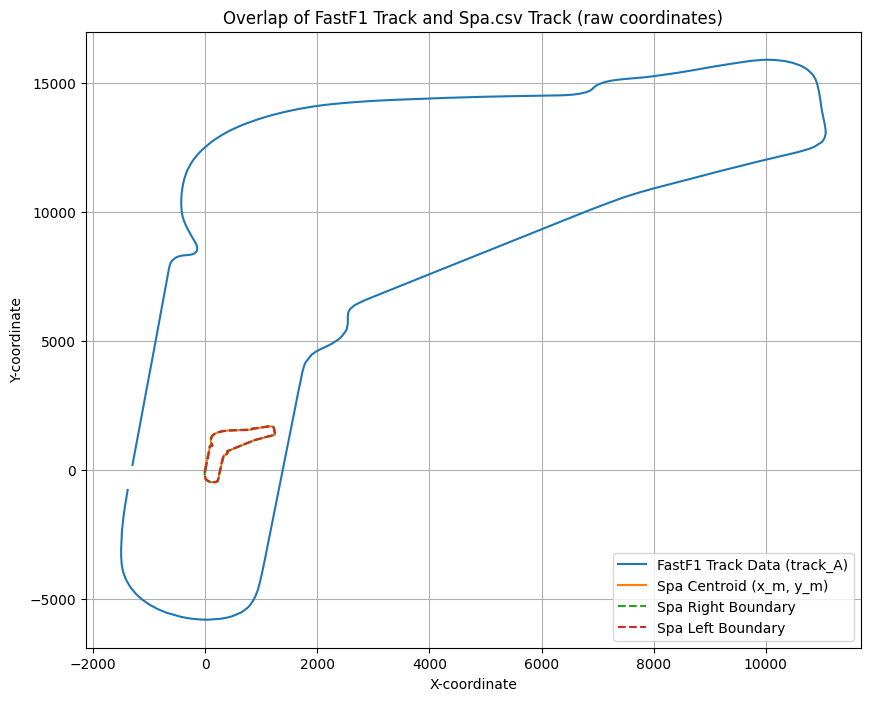

In [87]:
plt.figure(figsize=(10, 8))
plt.plot(track_A[:, 0], track_A[:, 1], label='FastF1 Track Data (track_A)', color='tab:blue')
plt.plot(track_B[:, 0], track_B[:, 1], label='Spa Centroid (x_m, y_m)', color='tab:orange')
# Plot raw left/right boundaries
plt.plot(right_boundary[:, 0], right_boundary[:, 1], label='Spa Right Boundary', color='tab:green', linestyle='--')
plt.plot(left_boundary[:, 0], left_boundary[:, 1], label='Spa Left Boundary', color='tab:red', linestyle='--')
plt.title('Overlap of FastF1 Track and Spa.csv Track (raw coordinates)')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.legend()
plt.grid(True)
plt.show()

# Normalization to [0,1]

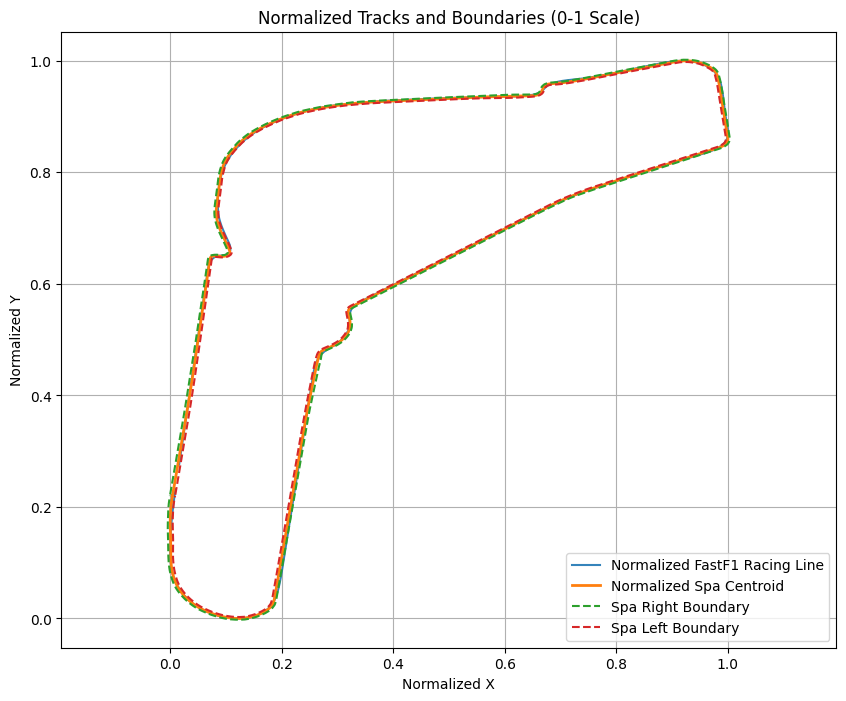

In [88]:
# Normalize track_A to [0,1] (racing line)
min_x_a = track_A[:, 0].min()
max_x_a = track_A[:, 0].max()
min_y_a = track_A[:, 1].min()
max_y_a = track_A[:, 1].max()
dx_a = max_x_a - min_x_a
dy_a = max_y_a - min_y_a
dx_a = dx_a if dx_a != 0 else 1.0
dy_a = dy_a if dy_a != 0 else 1.0
normalized_track_A = np.column_stack([
    (track_A[:, 0] - min_x_a) / dx_a,
    (track_A[:, 1] - min_y_a) / dy_a
])

# Normalize centroid (track_B) and boundaries using the same centroid mins/maxes
min_x_b = track_B[:, 0].min()
max_x_b = track_B[:, 0].max()
min_y_b = track_B[:, 1].min()
max_y_b = track_B[:, 1].max()
dx_b = max_x_b - min_x_b
dy_b = max_y_b - min_y_b
dx_b = dx_b if dx_b != 0 else 1.0
dy_b = dy_b if dy_b != 0 else 1.0

normalized_track_B = np.column_stack([
    (track_B[:, 0] - min_x_b) / dx_b,
    (track_B[:, 1] - min_y_b) / dy_b
])
# Normalize boundaries with the same centroid scaling
normalized_right = np.column_stack([
    (right_boundary[:, 0] - min_x_b) / dx_b,
    (right_boundary[:, 1] - min_y_b) / dy_b
])
normalized_left = np.column_stack([
    (left_boundary[:, 0] - min_x_b) / dx_b,
    (left_boundary[:, 1] - min_y_b) / dy_b
])

# Plot normalized tracks: racing line (FastF1), centroid (Spa), and left/right boundaries
plt.figure(figsize=(10, 8))
plt.plot(normalized_track_A[:, 0], normalized_track_A[:, 1], label='Normalized FastF1 Racing Line', color='tab:blue', alpha=0.9)
plt.plot(normalized_track_B[:, 0], normalized_track_B[:, 1], label='Normalized Spa Centroid', color='tab:orange', linewidth=2)
plt.plot(normalized_right[:, 0], normalized_right[:, 1], label='Spa Right Boundary', color='tab:green', linestyle='--')
plt.plot(normalized_left[:, 0], normalized_left[:, 1], label='Spa Left Boundary', color='tab:red', linestyle='--')
plt.title('Normalized Tracks and Boundaries (0-1 Scale)')
plt.xlabel('Normalized X')
plt.ylabel('Normalized Y')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

# Plotting

In [89]:
import plotly.graph_objects as go

# Build interactive figure with raw coordinates
fig = go.Figure()

# Add normalized traces but keep them hidden by default (toggle via legend)
fig.add_trace(go.Scatter(x=normalized_track_A[:, 0], y=normalized_track_A[:, 1], mode='lines', name='Normalized Racing Line', line=dict(color='blue', dash='dot'), visible=True))
fig.add_trace(go.Scatter(x=normalized_track_B[:, 0], y=normalized_track_B[:, 1], mode='lines', name='Normalized Centroid', line=dict(color='orange', dash='dot'), visible=True))
fig.add_trace(go.Scatter(x=normalized_right[:, 0], y=normalized_right[:, 1], mode='lines', name='Normalized Right Boundary', line=dict(color='green', dash='dot'), visible=True))
fig.add_trace(go.Scatter(x=normalized_left[:, 0], y=normalized_left[:, 1], mode='lines', name='Normalized Left Boundary', line=dict(color='red', dash='dot'), visible=True))

fig.update_layout(title='Interactive Track & Boundaries (raw coordinates)',
                  xaxis_title='X', yaxis_title='Y',
                  legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1))
# Keep equal aspect ratio for accurate geometry
fig.update_yaxes(scaleanchor='x', scaleratio=1)

fig.show()

In [90]:
# Export track CSV that preserves original Spa.csv columns, appends raw left/right coordinates,
# and also appends normalized centroid/left/right coordinates (0..1).
# We intentionally DO NOT normalize width columns (keep them as metres) but we drop them from
# the exported file per previous request. If you want widths included, remove the drop below.
from pathlib import Path

# Safety checks: ensure arrays align with faridata
n = len(faridata)
assert track_B.shape[0] == n, "track_B length mismatch with faridata"
assert left_boundary.shape[0] == n, "left_boundary length mismatch with faridata"
assert right_boundary.shape[0] == n, "right_boundary length mismatch with faridata"

# Copy original table to preserve exact format/columns
out_df = faridata.copy()
# Optionally drop widths from export (you asked earlier to exclude them)
out_df = out_df.drop(columns=['w_tr_left_m', 'w_tr_right_m'], errors='ignore')

# Add raw left/right coordinates (metres)
out_df['left_x_m']  = left_boundary[:, 0]
out_df['left_y_m']  = left_boundary[:, 1]
out_df['right_x_m'] = right_boundary[:, 0]
out_df['right_y_m'] = right_boundary[:, 1]

# Compute centroid bounding box for normalization (use centroid track_B or x_m/y_m)
# prefer using the same reference used earlier (track_B)
min_x_b = track_B[:, 0].min()
max_x_b = track_B[:, 0].max()
min_y_b = track_B[:, 1].min()
max_y_b = track_B[:, 1].max()
dx_b = max_x_b - min_x_b if (max_x_b - min_x_b) != 0 else 1.0
dy_b = max_y_b - min_y_b if (max_y_b - min_y_b) != 0 else 1.0

# Append normalized columns (0..1) alongside the raw coords
out_df['centroid_x_norm'] = (out_df['x_m'] - min_x_b) / dx_b
out_df['centroid_y_norm'] = (out_df['y_m'] - min_y_b) / dy_b
out_df['left_x_norm']     = (out_df['left_x_m'] - min_x_b) / dx_b
out_df['left_y_norm']     = (out_df['left_y_m'] - min_y_b) / dy_b
out_df['right_x_norm']    = (out_df['right_x_m'] - min_x_b) / dx_b
out_df['right_y_norm']    = (out_df['right_y_m'] - min_y_b) / dy_b

# Clip to [0,1] to protect against tiny numerical overshoot
for c in ['centroid_x_norm','centroid_y_norm','left_x_norm','left_y_norm','right_x_norm','right_y_norm']:
    out_df[c] = out_df[c].clip(0.0, 1.0)

# Choose output directory and filename derived from a reasonable source path
out_dir = Path('NewData')
out_dir.mkdir(parents=True, exist_ok=True)

# Try to infer source filename if possible
candidates = [Path('OldData/Spa.csv'), Path('Spa.csv')]
src_path = next((p for p in candidates if p.exists()), None)
if src_path is None:
    out_name = out_dir / 'track_with_boundaries_normalized.csv'
else:
    out_name = out_dir / (src_path.stem + '_with_boundaries_normalized.csv')

out_df.to_csv(out_name, index=False)
print(f"Saved track CSV (original columns + boundaries + normalized coords) to {out_name} ({len(out_df)} rows)")

Saved track CSV (original columns + boundaries + normalized coords) to NewData\Spa_with_boundaries_normalized.csv (1159 rows)
